This week I would like to explore PyTorch in the realm of distilling knowlege/transfer learning/pre-trained. I think these methods will be especially useful when it comes to a larger, full-scale project where it may be best to fine-tune rather than start from scratch.

Torchvision has some great resources for this that I will be using:
https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html

Please have the other files in the same directory before running.

In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import matplotlib.pyplot as plt
import pycocotools

As suggested in the tutorial I am going to be using the PennFudanDataset. This dataset is for pedestrian detection taken from around UPenn. They provided a script below to make a dataset an object.

In [14]:
import os
import numpy as np
import torch
from PIL import Image

if __name__=="__main__":

    class PennFudanDataset(object):
        def __init__(self, root, transforms):
            self.root = root
            self.transforms = transforms
            # load all image files, sorting them to
            # ensure that they are aligned
            self.imgs = list(sorted(os.listdir(os.path.join(root, "PNGImages"))))
            self.masks = list(sorted(os.listdir(os.path.join(root, "PedMasks"))))

        def __getitem__(self, idx):
            # load images ad masks
            img_path = os.path.join(self.root, "PNGImages", self.imgs[idx])
            mask_path = os.path.join(self.root, "PedMasks", self.masks[idx])
            img = Image.open(img_path).convert("RGB")
            # note that we haven't converted the mask to RGB,
            # because each color corresponds to a different instance
            # with 0 being background
            mask = Image.open(mask_path)
            # convert the PIL Image into a numpy array
            mask = np.array(mask)
            # instances are encoded as different colors
            obj_ids = np.unique(mask)
            # first id is the background, so remove it
            obj_ids = obj_ids[1:]

            # split the color-encoded mask into a set
            # of binary masks
            masks = mask == obj_ids[:, None, None]

            # get bounding box coordinates for each mask
            num_objs = len(obj_ids)
            boxes = []
            for i in range(num_objs):
                pos = np.where(masks[i])
                xmin = np.min(pos[1])
                xmax = np.max(pos[1])
                ymin = np.min(pos[0])
                ymax = np.max(pos[0])
                boxes.append([xmin, ymin, xmax, ymax])

            # convert everything into a torch.Tensor
            boxes = torch.as_tensor(boxes, dtype=torch.float32)
            # there is only one class
            labels = torch.ones((num_objs,), dtype=torch.int64)
            masks = torch.as_tensor(masks, dtype=torch.uint8)

            image_id = torch.tensor([idx])
            area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
            # suppose all instances are not crowd
            iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

            target = {}
            target["boxes"] = boxes
            target["labels"] = labels
            target["masks"] = masks
            target["image_id"] = image_id
            target["area"] = area
            target["iscrowd"] = iscrowd

            if self.transforms is not None:
                img, target = self.transforms(img, target)

            return img, target

        def __len__(self):
            return len(self.imgs)

### Fine Tuning

The code above takes the filepath and transformations pertaining for a desired dataset. It loads the image and masks (used for the objects we want to detect) and draws the bounding box for each image. Then, the images are converted into a torch tensor and the boxes, labels, masks, image id, area, and whether there are multiple classes in an image are saved as a dictionary and returned.

For the pre-trained model, I am going to use Faster R-CNN. It appears Faster R-CNN is commonly used as an architecture, modified, and fine-tuned. Pytorch provides us with a version of Faster R-CNN with ResNet-50 with a feature pyramid network as the backbone (https://pytorch.org/docs/stable/torchvision/models.html)

In [3]:
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

num_classes = 2 #1 class pedestrian and background
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)


Here we load a pre-trained model with a ResNet-50 backbone, specify the number of classes, the number of input features, and replace the regoin of interest heads with our own.

In the tutorial they are going to fine-tune from a pretrained model and not changing the backbone. This will be something I will explore after going through the tutorial. The guide also wants to look at the instance segmentation masks and, therefore, will be using Mask R-CNN.

In [4]:
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor


def get_model_instance_segmentation(num_classes):
    # load an instance segmentation model pre-trained pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model

In [5]:
import transforms as T
import utils

def get_transform(train):
    transforms = []
    transforms.append(T.ToTensor())
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

Here we loaded the pre-trained Mask RCNN model and have a function that will take our training data, convert it to a tensor, and randomly flip it with probaiblity of 0.5. Next we'll

In [6]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
dataset = PennFudanDataset('PennFudanPed', get_transform(train=True))
data_loader = torch.utils.data.DataLoader(
 dataset, batch_size=2, shuffle=True, num_workers=0,
 collate_fn=utils.collate_fn)
# For Training
images,targets = next(iter(data_loader))
images = list(image for image in images)
targets = [{k: v for k, v in t.items()} for t in targets]
output = model(images,targets)   # Returns losses and detections
# For inference
model.eval()
x = [torch.rand(3, 300, 400), torch.rand(3, 500, 400)]
predictions = model(x)

C:\Users\JT\Anaconda3\envs\deeplearning\lib\site-packages\torch\nn\functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
C:\Users\JT\Anaconda3\envs\deeplearning\lib\site-packages\torchvision\ops\boxes.py:101: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  ..\torch\csrc\utils\python_arg_parser.cpp:766.)
  keep = keep.nonzero().squeeze(1)


This next block of code is taking our pre-trained model and finetuning it on the PennFudanPed data.

In [15]:
from engine import train_one_epoch, evaluate
import utils


def main(num_epochs):
    # train on the GPU or on the CPU, if a GPU is not available
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

    # our dataset has two classes only - background and person
    num_classes = 2
    # use our dataset and defined transformations
    dataset = PennFudanDataset('PennFudanPed', get_transform(train=True))
    dataset_test = PennFudanDataset('PennFudanPed', get_transform(train=False))

    # split the dataset in train and test set
    indices = torch.randperm(len(dataset)).tolist()
    dataset = torch.utils.data.Subset(dataset, indices[:-50])
    dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

    # define training and validation data loaders
    data_loader = torch.utils.data.DataLoader(
        dataset, batch_size=2, shuffle=True, num_workers=0,
        collate_fn=utils.collate_fn)

    data_loader_test = torch.utils.data.DataLoader(
        dataset_test, batch_size=1, shuffle=False, num_workers=0,
        collate_fn=utils.collate_fn)

    # get the model using our helper function
    model = get_model_instance_segmentation(num_classes)

    # move model to the right device
    model.to(device)

    # construct an optimizer
    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.SGD(params, lr=0.005,
                                momentum=0.9, weight_decay=0.0005)
    # and a learning rate scheduler
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                                   step_size=3,
                                                   gamma=0.1)

    for epoch in range(num_epochs):
        # train for one epoch, printing every 60 iterations
        train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=60)
        # update the learning rate
        lr_scheduler.step()
        # evaluate on the test dataset
        evaluate(model, data_loader_test, device=device)
      
if __name__=='__main__':
    main(10)


Results after 1 epoch:

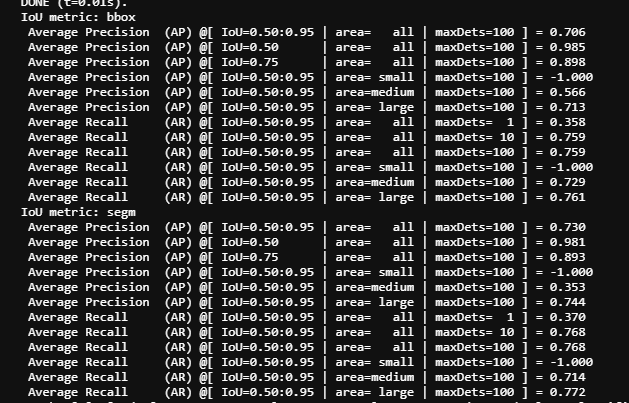

Results after 10 epochs:

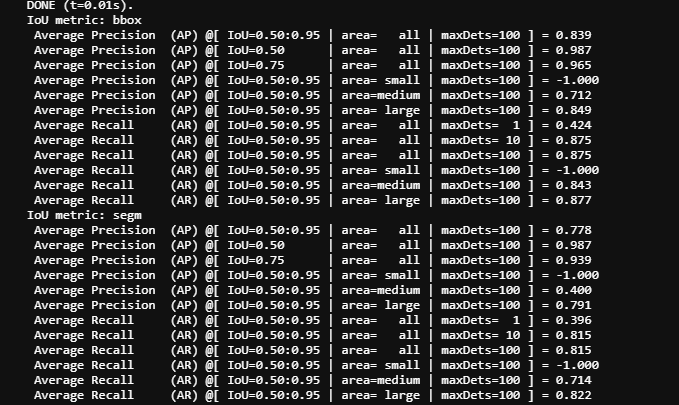

Using fine tuning we went from a COCO mAP of 70.6 and mask mAP of 70.3 to 83.9 and 77.8, respectively. Pretty good improvement over just 10 epochs! The tutorial didn't explicity show how to modify the model to a different backbone, so I'm going to do that next. PyTorch has several versions of ShuffleNet v2 at varying levels of complexity. To aid in the speed with training I'm going to use the 1x version as opposed to the 0.5x, 1.5x, or 2x versions where these numbers are the multipliers of the output channels.

### Modifying the model to add a different backbone

In [8]:
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

backbone = torchvision.models.shufflenet_v2_x1_0(pretrained=True)
backbone.out_channels = 1024
anchor_generator = AnchorGenerator(sizes=((32, 64, 128, 256, 512),),
                                   aspect_ratios=((0.5, 1.0, 2.0),))
roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=[0],
                                                output_size=7,
                                                sampling_ratio=2)

model = FasterRCNN(backbone,
                   num_classes=2,
                   rpn_anchor_generator=anchor_generator,
                   box_roi_pool=roi_pooler)

The tutorial has mobilenet_v2 as the background, which I am somewhat familiar with. However, since I have written a previous report and coded ShuffleNet v2 I am going to use that as the backbone network. I can see this method being very useful for inserting custom backbones into popular pre-trained architectures. Furthermore, I can see value in adding such functionality to custom architectures to allow the backbone network to be changed with ease.

In [9]:
#training new model
if __name__=='__main__':
    main(10)


Epoch: [0]  [ 0/60]  eta: 0:00:32  lr: 0.000090  loss: 3.7531 (3.7531)  loss_classifier: 0.5691 (0.5691)  loss_box_reg: 0.2394 (0.2394)  loss_mask: 2.8901 (2.8901)  loss_objectness: 0.0534 (0.0534)  loss_rpn_box_reg: 0.0010 (0.0010)  time: 0.5496  data: 0.0459  max mem: 3788
Epoch: [0]  [59/60]  eta: 0:00:00  lr: 0.005000  loss: 0.3126 (0.7574)  loss_classifier: 0.0371 (0.1489)  loss_box_reg: 0.1066 (0.1999)  loss_mask: 0.1569 (0.3932)  loss_objectness: 0.0012 (0.0084)  loss_rpn_box_reg: 0.0052 (0.0070)  time: 0.6505  data: 0.0402  max mem: 3788
Epoch: [0] Total time: 0:00:37 (0.6260 s / it)
creating index...
index created!
Test:  [ 0/50]  eta: 0:00:07  model_time: 0.1376 (0.1376)  evaluator_time: 0.0050 (0.0050)  time: 0.1566  data: 0.0130  max mem: 3788
Test:  [49/50]  eta: 0:00:00  model_time: 0.1162 (0.1253)  evaluator_time: 0.0040 (0.0068)  time: 0.1407  data: 0.0136  max mem: 3788
Test: Total time: 0:00:07 (0.1490 s / it)
Averaged stats: model_time: 0.1162 (0.1253)  evaluator_tim

Looks like we couldn't get much improvement when using ShuffleNet at 1x complexity. We were stuck around 82.6 AP and 75.9 for the mask AP. The helper functions provided by the tutorial output quite a lot of text, so I will only provide the information from the last training epoch.

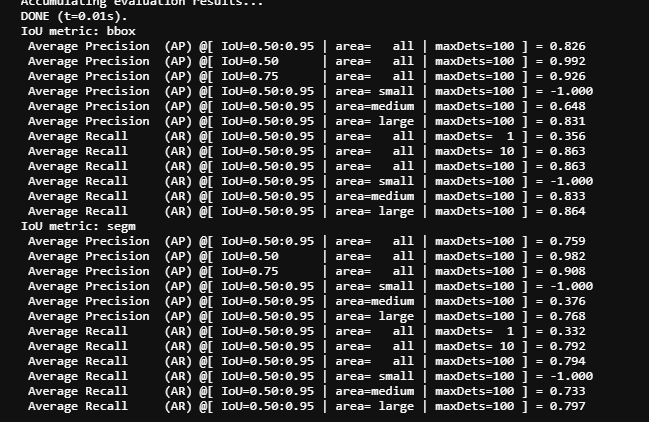

## Modifying the Backbone Architecture

These approaches are quite simplistic and far easier to implement than I expected even with much assistance provided by the helper functions. Something that the tutorial did not address is how we would change the existing architecture itself. I investigated what it would take to edit the pre-trained model without the code itself using the attributes and it appears quite difficult. It would make more sense to take the model I am interested in, initialize the layers I want with the state dict (perhaps freeze them) and train new randomly initialized blocks. I'm going to take the ShuffleNet v2 code from torchvision's github and modify it below.

I am using https://www.youtube.com/watch?v=qaDe0qQZ5AQ as a guide on how to change the model architecture, however, I won't be working with exactly the same model and performing the exact same changes. This post on the PyTorch forums was also helpful: https://discuss.pytorch.org/t/insert-new-layer-in-the-middle-of-a-pre-trained-model/12414.

Here I am going to take the code for a non-local block and insert it into the ShuffleNet v2 backbone model. Here I'm going to only implement the gaussian version of the non local block.

In [10]:
class gaussian_nonlocal(nn.Module):
    def __init__(self, in_channels):
        super(gaussian_nonlocal, self).__init__()

        self.in_channels = in_channels
        self.block_channels = in_channels // 2
            
        self.g = nn.Conv2d(in_channels = self.in_channels, out_channels = self.block_channels, kernel_size = 1)
        
        self.Wz = nn.Sequential(
             nn.Conv2d(in_channels=self.block_channels, out_channels=self.in_channels, kernel_size=1),
             nn.BatchNorm2d(self.in_channels)
         )
    
    def forward(self, x):
        #x of size N, C, H, W
        
        n, c, h, w = x.size()
        
        identity = x
        
        x = self.g(x)
        
        #gaussian does not use 1x1 conv, change to 
        theta = x.view(n, self.block_channels, -1)
        phi = x.view(n, self.block_channels, -1)
        theta = theta.transpose(1,2)
        f = torch.matmul(theta, phi)
        
        f = F.softmax(f)
        
        self.g = self.g.view(n, self.block_channels, -1)
        self.g = self.g.transpose(1,2)
        
        y = torch.matmul(f, g)
        y = y.transpose(1,2)
        y = y.view(n, self.block_channels, h, w)
        
        y = self.Wz(y)
        
        z = x + y
        return y

Before I get into implementing this, let's take a look at how this implementation of the non-local block works from the Non Local Network paper. We take our input channels and reduce the size by half such that when we include our residual connection and concatenate them, we still end up with the same amount of channels. Let's reference the image below:

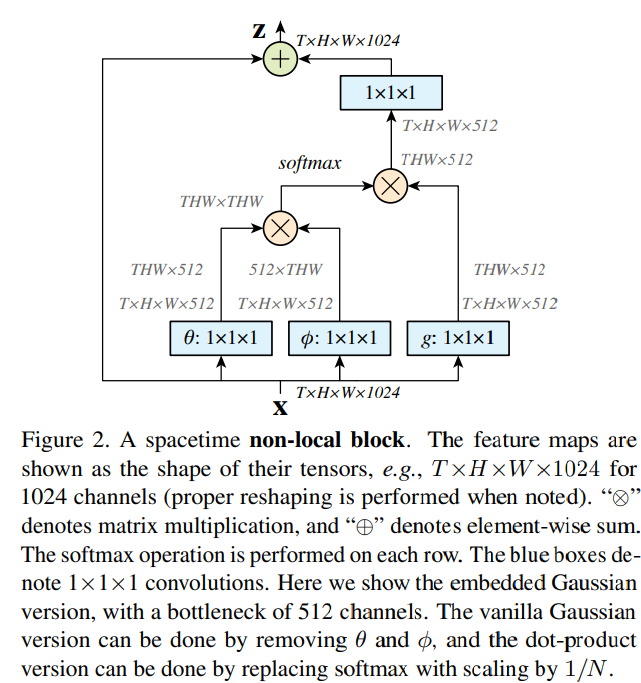

Since I am implementing the gaussian version, we simply take $\theta$ and $\phi$ as the input, $x$. For $g$ we still use 1x1 a convolution and change the shape such that we have $THW \times 512$. Similar reshaping is done for $\theta$ and $\phi$. We then multiply $\theta$ and $\phi$ and apply a softmax. Next, we multiply this result with $g$, reshape, and perform one last 1x1 convolution and a batch normalization. Since I am implementing this on to the residual path I am not including the residual path here as my residual connection already exists in my backbone model. Something to note, though, is that since I will be concatenating in my residual model and not performing element-wise addition, I am going to remove the last 1x1 convoltuon that expands the feature maps.

Let's instantiate a "new" pre-trained model so we can compare the results after 15 epochs from a model without these blocks.

In [11]:
backbone = torchvision.models.shufflenet_v2_x1_0(pretrained=True)
backbone.out_channels = 1024
anchor_generator = AnchorGenerator(sizes=((32, 64, 128, 256, 512),),
                                   aspect_ratios=((0.5, 1.0, 2.0),))
roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=[0],
                                                output_size=7,
                                                sampling_ratio=2)

model = FasterRCNN(backbone,
                   num_classes=2,
                   rpn_anchor_generator=anchor_generator,
                   box_roi_pool=roi_pooler)

#adding in the non-local blocks
model.backbone.stage2 = nn.Sequential(model.backbone.stage2, gaussian_nonlocal(58))
model.backbone.stage3 = nn.Sequential(model.backbone.stage3, gaussian_nonlocal(116))
model.backbone.stage4 = nn.Sequential(model.backbone.stage4, gaussian_nonlocal(232))

if __name__=='__main__':
    main(10)

Epoch: [0]  [ 0/60]  eta: 0:00:41  lr: 0.000090  loss: 2.8878 (2.8878)  loss_classifier: 0.7892 (0.7892)  loss_box_reg: 0.5378 (0.5378)  loss_mask: 1.5387 (1.5387)  loss_objectness: 0.0177 (0.0177)  loss_rpn_box_reg: 0.0045 (0.0045)  time: 0.6961  data: 0.0429  max mem: 3788
Epoch: [0]  [59/60]  eta: 0:00:00  lr: 0.005000  loss: 0.3446 (0.7032)  loss_classifier: 0.0397 (0.1596)  loss_box_reg: 0.1294 (0.2099)  loss_mask: 0.1455 (0.3190)  loss_objectness: 0.0017 (0.0086)  loss_rpn_box_reg: 0.0050 (0.0061)  time: 0.6105  data: 0.0373  max mem: 3788
Epoch: [0] Total time: 0:00:37 (0.6287 s / it)
creating index...
index created!
Test:  [ 0/50]  eta: 0:00:08  model_time: 0.1396 (0.1396)  evaluator_time: 0.0050 (0.0050)  time: 0.1616  data: 0.0150  max mem: 3788
Test:  [49/50]  eta: 0:00:00  model_time: 0.1092 (0.1214)  evaluator_time: 0.0050 (0.0086)  time: 0.1411  data: 0.0129  max mem: 3788
Test: Total time: 0:00:07 (0.1454 s / it)
Averaged stats: model_time: 0.1092 (0.1214)  evaluator_tim

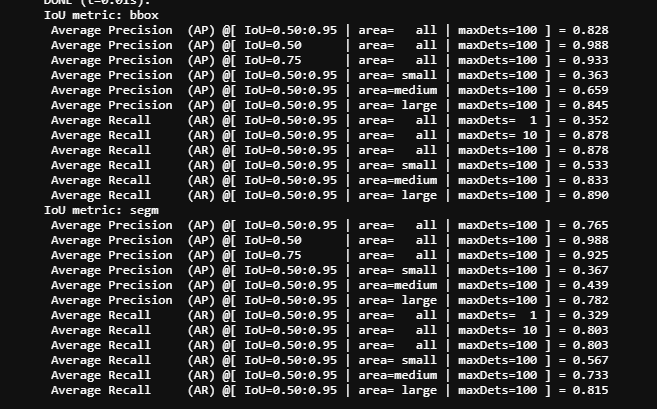

For the most part the results are very similar after 15 epochs for the model that was simply fine tuned and the one with the new blocks. What I think is likely is that the weights of the non-local layers need much many more epochs to learn that was given. Overall, I see these techniques being extremely useful especially when it comes to larger tasks. In many cases, it is not feasible to train a model from scratch and these techniques can allow for significantly faster training times even if the task is large through either fine tuning or transfer learning.

I'm going to take the original pre-trained model and freeze all the layers and only update our new global layers to see if we get any better performance. As noted in this blog post https://discuss.pytorch.org/t/how-the-pytorch-freeze-network-in-some-layers-only-the-rest-of-the-training/7088, this is quite simple and involves taking the parameters in our pre-trained model and setting requires_grad to False. I then add the new blocks, where the parameters will still be trained. When specifying the parameters to be trained by the optimizer, we include only the parameters where requires_grad evaluates to true by looping over the parameters.

In [ ]:
backbone = torchvision.models.shufflenet_v2_x1_0(pretrained=True)
backbone.out_channels = 1024
anchor_generator = AnchorGenerator(sizes=((32, 64, 128, 256, 512),),
                                   aspect_ratios=((0.5, 1.0, 2.0),))
roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=[0],
                                                output_size=7,
                                                sampling_ratio=2)

model = FasterRCNN(backbone,
                   num_classes=2,
                   rpn_anchor_generator=anchor_generator,
                   box_roi_pool=roi_pooler)

if __name__=='__main__':
    main(10)

for param in model.parameters():
    param.requires_grad = False


#adding in the non-local blocks
model.backbone.stage2 = nn.Sequential(model.backbone.stage2, gaussian_nonlocal(58))
model.backbone.stage3 = nn.Sequential(model.backbone.stage3, gaussian_nonlocal(116))
model.backbone.stage4 = nn.Sequential(model.backbone.stage4, gaussian_nonlocal(232))

if __name__=='__main__':
    main(20)

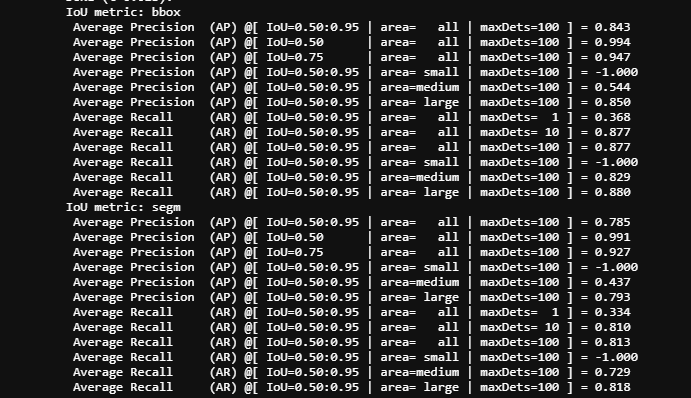